In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
%matplotlib inline
import matplotlib as mpl
import math
from dwave.system import DWaveSampler
import minorminer as mm
import dwave.inspector

In [2]:
# Use a D-Wave system as the sampler
f = open("token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='pegasus'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage_system6.1 was selected.


# Create the embedding on the target graph

In [3]:
#create a target graph
T=nx.Graph()
T.add_edges_from(sampler.edgelist)
T.add_nodes_from(sampler.nodelist)

we try to embed Nchains disconnected periodic chains (called rings) of 12 qubits each. We use N=12 qubits chains so that we may compare with the results of the other IBM paper.

In [4]:
#create a source graph
S=nx.Graph()
#spin chain length
Nlen=12
#number of chains
Nchains=100

#define the nodes in base chain
base_nodes=[]
for i in range(Nlen):
    base_nodes.append(i)
base_nodes=np.array(base_nodes)
#generate all the nodes
allnodes=[]
for i in range(Nchains):
    allnodes.append(list(base_nodes+Nlen*i))
#all_nodes is a list of length Nchains, each element is a list of length Nlen

#add nodes to source graph
for i in range(len(allnodes)):
    for j in range(len(allnodes[i])):
        S.add_node(allnodes[i][j])

#define the edges
#loop over all the chains you are trying to embed
for i in range(len(allnodes)):
    #extract current list of sites for this ring
    spinlist=allnodes[i]
    for j in range(len(spinlist)-1):
        #add the nearest neighbor interaction as an edge
        S.add_edge(spinlist[j],spinlist[j+1])
    #add the final edge which completes the periodic chain
    S.add_edge(spinlist[len(spinlist)-1],spinlist[0])

In [7]:
S.edges

EdgeView([(0, 1), (0, 11), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (12, 13), (12, 23), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19), (19, 20), (20, 21), (21, 22), (22, 23), (24, 25), (24, 35), (25, 26), (26, 27), (27, 28), (28, 29), (29, 30), (30, 31), (31, 32), (32, 33), (33, 34), (34, 35), (36, 37), (36, 47), (37, 38), (38, 39), (39, 40), (40, 41), (41, 42), (42, 43), (43, 44), (44, 45), (45, 46), (46, 47), (48, 49), (48, 59), (49, 50), (50, 51), (51, 52), (52, 53), (53, 54), (54, 55), (55, 56), (56, 57), (57, 58), (58, 59), (60, 61), (60, 71), (61, 62), (62, 63), (63, 64), (64, 65), (65, 66), (66, 67), (67, 68), (68, 69), (69, 70), (70, 71), (72, 73), (72, 83), (73, 74), (74, 75), (75, 76), (76, 77), (77, 78), (78, 79), (79, 80), (80, 81), (81, 82), (82, 83), (84, 85), (84, 95), (85, 86), (86, 87), (87, 88), (88, 89), (89, 90), (90, 91), (91, 92), (92, 93), (93, 94), (94, 95), (96, 97), (96, 107), (97, 98), (98, 99), (99, 100)

In [10]:
#use minorminer to embed this graph (it is really Nchain disconnect graphs)
#this may take a while

cond=0
count=0

while (cond==0 and count<1000):
    print(count)

    embedding=mm.find_embedding(S,T)

    #here we make sure that minorminor didn't make any chains 
    biggerthan1=[]
    for value in embedding.values():
        if len(value)>1:
            biggerthan1.append(value)
    #if the embedding has any chains we reject it and try again
    if len(biggerthan1)>0:
        print(len(biggerthan1),"chains")
        cond=0
        count+=1
    if count==999:
        print("reached max iterations")   
    
    #if there are no chains it's a goood embedding
    if len(biggerthan1)==0:
        cond=1
    
print(embedding)

density = len(embedding)/sampler.properties["num_qubits"]

print("density of qubits used: {}".format(density))

0
{0: [1788], 1: [1787], 11: [3549], 2: [3354], 3: [1681], 4: [3324], 5: [1696], 6: [3278], 7: [3279], 8: [1861], 9: [1862], 10: [3564], 12: [831], 13: [4219], 23: [4234], 14: [757], 15: [4249], 16: [4250], 17: [1057], 18: [4355], 19: [4354], 20: [908], 21: [4384], 22: [892], 24: [5062], 25: [1496], 35: [1406], 26: [5032], 27: [1556], 28: [5048], 29: [5047], 30: [1421], 31: [4957], 32: [4972], 33: [1316], 34: [5016], 36: [507], 37: [5176], 47: [5237], 38: [461], 39: [5072], 40: [5071], 41: [446], 42: [5102], 43: [567], 44: [568], 45: [5252], 46: [627], 48: [2817], 49: [5204], 59: [2818], 50: [2742], 51: [2743], 52: [5279], 53: [2637], 54: [2636], 55: [5159], 56: [2682], 57: [2683], 58: [5384], 60: [2431], 61: [3358], 71: [3328], 62: [3343], 63: [2387], 64: [2386], 65: [3207], 66: [2461], 67: [3268], 68: [2521], 69: [3208], 70: [2506], 72: [856], 73: [3274], 83: [3244], 74: [886], 75: [887], 76: [3424], 77: [902], 78: [3289], 79: [841], 80: [3228], 81: [3213], 82: [811], 84: [1223], 85:

In [30]:
embedding[6]

[3278]

setting the J and h values on each used qubit

In [14]:
jval = -1
hval = -0.1

#set the coupler's interaction to -1 (FM) 
couplers={}
for edge in list(S.edges):
    spin0=edge[0]
    spin1=edge[1]
    qubit0=embedding.get(spin0)[0]
    qubit1=embedding.get(spin1)[0]
    couplers.update({(qubit0,qubit1):jval})

#set the magnetic fields  
hdict={}
#set initial state (+1)
initial={}
for node in list(S.nodes):
    spin0=node
    qubit0=embedding.get(spin0)[0]
    hdict.update({qubit0:hval})
    initial.update({qubit0:1.0})


info on the sampler properties

In [15]:
print("Chosen topology is:")
print(sampler.properties["topology"])
print("Maximum anneal-schedule points: {}".format(sampler.properties["max_anneal_schedule_points"]))
print("Annealing time range: {} (in us)".format(sampler.properties["annealing_time_range"]))

max_slope = 1.0/sampler.properties["annealing_time_range"][0]

print("Maximum slope allowed on this solver is {:.2f}.".format(max_slope))
print("J range: {}".format(sampler.properties["j_range"]))
print("h range: {}".format(sampler.properties["h_range"]))


Chosen topology is:
{'type': 'pegasus', 'shape': [16]}
Maximum anneal-schedule points: 12
Annealing time range: [0.5, 2000.0] (in us)
Maximum slope allowed on this solver is 2.00.
J range: [-1.0, 1.0]
h range: [-4.0, 4.0]


# test run

In [17]:
#test_run
pausetime = 50    
num_reads = 10
sval = 0.3
rev_sch=[[0.0, 1.0], [1/max_slope, sval], [1/max_slope + pausetime, sval],
            [2/max_slope + pausetime, 1.0]]
h_sch = [[0.0, 0.0], [1/max_slope, 1.0], [1/max_slope + pausetime, 1.0],
        [2/max_slope + pausetime, 0.0]]

response = sampler.sample_ising(h=hdict,
J=couplers,
num_reads=num_reads,
anneal_schedule=rev_sch,
initial_state=initial,
h_gain_schedule=h_sch,
answer_mode='raw',
reduce_intersample_correlation=True,
#reinitialize the initial state after reverse annealing                            
reinitialize_state=True)

In [19]:
print(response)

  32 33 43 44 82 92 96 97 102 107 111 112 115 124 133 ... 5727  energy num_oc.
3 +1 +1 -1 -1 +1 +1 +1 +1  -1  +1  +1  +1  +1  +1  -1 ...   +1 -1300.6       1
6 -1 -1 +1 +1 +1 -1 +1 +1  +1  -1  +1  +1  +1  +1  +1 ...   +1 -1294.8       1
9 +1 +1 +1 +1 +1 +1 +1 +1  +1  +1  +1  +1  +1  +1  +1 ...   +1 -1294.6       1
4 +1 +1 +1 +1 +1 +1 +1 +1  +1  +1  +1  +1  +1  +1  +1 ...   +1 -1294.0       1
5 +1 +1 +1 +1 +1 +1 +1 +1  +1  +1  +1  +1  +1  +1  +1 ...   +1 -1293.6       1
8 +1 +1 +1 +1 +1 +1 +1 +1  +1  +1  +1  +1  +1  +1  +1 ...   +1 -1289.8       1
7 +1 +1 +1 +1 +1 +1 +1 +1  +1  +1  +1  +1  +1  +1  +1 ...   +1 -1287.0       1
2 +1 +1 +1 +1 +1 +1 +1 +1  +1  +1  +1  +1  +1  +1  +1 ...   +1 -1276.8       1
1 +1 +1 +1 +1 +1 +1 +1 +1  +1  +1  +1  +1  +1  +1  +1 ...   +1 -1273.2       1
0 +1 +1 +1 +1 +1 +1 +1 +1  +1  +1  +1  +1  +1  +1  +1 ...   +1 -1272.0       1
['SPIN', 10 rows, 10 samples, 1200 variables]


In [21]:
response.info

{'timing': {'qpu_sampling_time': 9791.0,
  'qpu_anneal_time_per_sample': 51.0,
  'qpu_readout_time_per_sample': 169.78,
  'qpu_access_time': 25713.57,
  'qpu_access_overhead_time': 3066.43,
  'qpu_programming_time': 15922.57,
  'qpu_delay_time_per_sample': 758.32,
  'post_processing_overhead_time': 122.0,
  'total_post_processing_time': 122.0},
 'problem_id': 'fec1d52a-f730-4e6b-9d0e-527de7e2f6b2'}

In [28]:
#find which index is a given node. 
np.argwhere(np.array(response.variables) == 96)[0][0]

6

In [32]:
indice = []
for i in range(Nlen):
    indice.append(np.argwhere(np.array(response.variables) == embedding[i])[0][0])

print(indice)

[376, 375, 685, 356, 672, 358, 663, 664, 384, 385, 738, 733]


In [48]:
chain_record = np.zeros((num_reads, Nlen))
avg_m = np.zeros(num_reads)
for m in range(num_reads):
    chain_record[m,:] = response.record['sample'][m,indice]
    avg_m[m] = np.mean(chain_record[m,:])

print(np.mean(avg_m))

0.8833333333333332


In [50]:
avg_m = np.zeros(num_reads*Nchains)
for j in range(Nchains):
    indice = []
    for i in range(Nlen*j, Nlen*(j+1)):
        indice.append(np.argwhere(np.array(response.variables) == embedding[i])[0][0])
    
    chain_record = np.zeros((num_reads, Nlen))
    for m in range(num_reads):
        chain_record[m,:] = response.record['sample'][m,indice]
        avg_m[j*num_reads + m] = np.mean(chain_record[m,:])


This is an important function: it allows to reconstruct the chain's data from the full data itself.

In [52]:
print('avg M_z',np.mean(avg_m))
print('var M_z',np.var(avg_m))

avg M_z 0.9036666666666667
var M_z 0.15583099999999997


# doing the run itself

note: parameters for the IBM-spectroscopy paper

J=1, h=0.3, g=0.25, t=30, dt=0.4

Time steps = 75
Circuits = 76

Shots = 8192

For the D-Wave machine, we have that at s=0.357, A(s)/B(s) = g/J = 0.25.
We also have s=0.3, A(s)/B(s) = g/J ~ 0.5.

In [8]:
#note that this h_gain_schedule might have too high of a slope.

def run_specific_pause(sval, pausetime, num_reads, check_time):        
    #reverse anneal schedule (change as needed. but, must start with [0,1] and end at [tf,1])
    rev_sch=[[0.0, 1.0], [(1 - sval)/2, sval], [(1 - sval)/2 + pausetime, sval],
            [2*(1 - sval)/2 + pausetime, 1.0]]

    h_sch = [[0.0, 0.0], [(1 - sval)/2, 1.0], [(1 - sval)/2 + pausetime, 1.0],
            [2*(1 - sval)/2 + pausetime, 0.0]]

    #print("reverse anneal schedule:")
    #print(rev_sch)
    #print("\n")
    mag_avg = 0
    mag_err = 0

    if check_time:
        print("pausetime = {}".format(pausetime))
        estimated_runtime = sampler.solver.estimate_qpu_access_time(num_qubits = len(initial), h=hdict,
            J=couplers,
            num_reads=num_reads,
            anneal_schedule=rev_sch,
            initial_state=initial,
            h_gain_schedule=h_sch,
            answer_mode='raw',
            reduce_intersample_correlation=True,
            #reinitialize the initial state after reverse annealing                            
            reinitialize_state=True)    
        print("Estimate of {:.0f}us ({:.3f} s) on {}".format(estimated_runtime, estimated_runtime/10**6, sampler.solver.name)) 
    else:
        response = sampler.sample_ising(h=hdict,
        J=couplers,
        num_reads=num_reads,
        anneal_schedule=rev_sch,
        initial_state=initial,
        h_gain_schedule=h_sch,
        answer_mode='raw',
        reduce_intersample_correlation=True,
        #reinitialize the initial state after reverse annealing                            
        reinitialize_state=True)

        #store the Z magnetization
        for i in range(len(response.record)):
            mag_avg += np.mean(response.record[i][0])
            mag_err += np.std(response.record[i][0])
        mag_avg = mag_avg/len(response.record)
        mag_err = mag_err/len(response.record)

    return mag_avg, mag_err

    

In [10]:
#set vals

sval=0.3
#pausetime = 15
pause_list = np.linspace(1, 40, 2*39+1) 
num_reads = 100

mag_vals = np.zeros(len(pause_list))
mag_errs = np.zeros(len(pause_list))

for j in range(len(pause_list)):
    mag_vals[j], mag_errs[j] = run_specific_pause(sval, pause_list[j], num_reads, False)
    print("done with s={}".format(pause_list[j]))
    print("\n")


done with s=1.0


done with s=1.5


done with s=2.0


done with s=2.5


done with s=3.0


done with s=3.5


done with s=4.0


done with s=4.5


done with s=5.0


done with s=5.5


done with s=6.0


done with s=6.5


done with s=7.0


done with s=7.5


done with s=8.0


done with s=8.5


done with s=9.0


done with s=9.5


done with s=10.0


done with s=10.5


done with s=11.0


done with s=11.5


done with s=12.0


done with s=12.5


done with s=13.0


done with s=13.5


done with s=14.0


done with s=14.5


done with s=15.0


done with s=15.5


done with s=16.0


done with s=16.5


done with s=17.0


done with s=17.5


done with s=18.0


done with s=18.5


done with s=19.0


done with s=19.5


done with s=20.0


done with s=20.5


done with s=21.0


done with s=21.5


done with s=22.0


done with s=22.5


done with s=23.0


done with s=23.5


done with s=24.0


done with s=24.5


done with s=25.0


done with s=25.5


done with s=26.0


done with s=26.5


done with s=27.0


done with s

SolverFailureError: Problem not accepted because user vdrouin@physics.rutgers.edu has insufficient remaining solver access time in project DEV

I have a guess that these $t$ values are too small - need higher values to see oscillations??

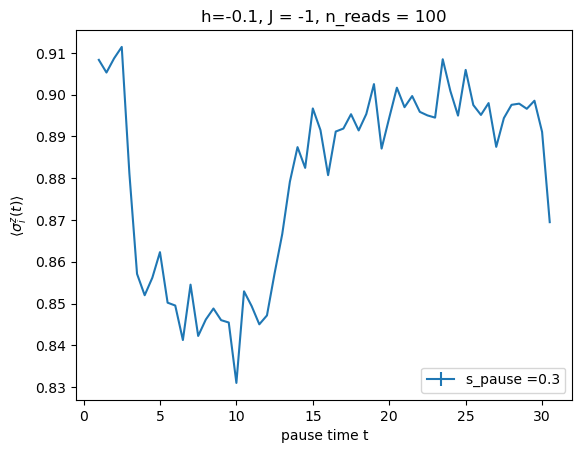

In [14]:

fig = plt.figure()
x = pause_list[:60]
y = mag_vals[:60]
yerr = 0*mag_errs[:60]

plt.errorbar(x, y, yerr=yerr, label='s_pause ={}'.format(sval))
plt.title('h={}, J = {}, n_reads = {}'.format(hval, jval, num_reads))
plt.ylabel(r"$\langle \sigma^z_i (t) \rangle$")
plt.xlabel("pause time t")
plt.legend(loc='lower right')
#plt.ylim([0.99, 1.01])

#note - BIIIIG error bars!

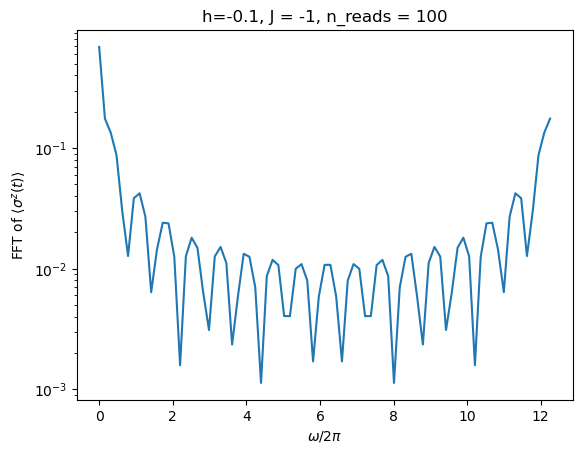

In [17]:
fftvals = np.abs(np.fft.fft(mag_vals, norm='forward'))
y = fftvals
x = np.arange(0, len(mag_vals), 1)*2*np.pi/pause_list[-1]
plt.plot(x, y, label='s_pause ={}'.format(sval))
plt.title('h={}, J = {}, n_reads = {}'.format(hval, jval, num_reads))
plt.yscale('log')
plt.ylabel(r"FFT of $\langle  \sigma^z (t)\rangle$")
plt.xlabel(r"$\omega/2\pi$");
#plt.xlim((0,6))

# Measure in the X and Y basis

Of course we measure the Z basis, but we can post-process it to "measure" in X and Y. See Chris' note. Works for small chains ($N < 20$). Need to decompose results array into 300 arrays of results for a given chain. It is highly possible that we can only observe the oscillations in the $X$ or $Y$ basis.

See Notebook!, can use qutip to get a tensor product for the $Z \times I \times I ...$ operators that are then sandwiched between $|\Psi>_z$. 

For this, you need the raw data-file, no spin-reversal transformation, and then extract the 12-bit strings one by one in a different file. Then, run anoter program to extract a dict of how often some specific bitstrings (for $N=12$, there are $2^{12}$ of them) appear.

# h-gain schedule

We can set an h-gain schedule, so that, in the reverse annealing, we specifiy $h(t) = [[0,0], [(1-s),h], [(1-s)+t_{p}, h], [2*(1-s) + t_p, 0]]$. Therefore, the time evolution after the quench is the only one that has a term with $g \neq h \neq 0$. At each ends on the reverse annealing steps, the Hamiltonian is only $H = -J \sum_{i=1}^{N-1} \sigma^z_i \sigma^z_{i+1}$.

See this https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.5.013224 for some insight